# TensorFlow powerspectrum

In [1]:
from halotools.sim_manager import CachedHaloCatalog
from halotools.empirical_models import PrebuiltHodModelFactory
from halotools.mock_observables.two_point_clustering import tpcf
from halotools.mock_observables import return_xyz_formatted_array

from tensorflow_probability import edward2 as ed
from diffhod.components import Zheng07Cens, Zheng07SatsRelaxedBernoulli, NFWProfile

from flowpm.utils import cic_paint
import tensorflow as tf
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/francois/repo/DHOD/diffhod/components.py:9: UserWarning: tfp.edward2 module is deprecated and will be removed on 2019-12-01. Use https://github.com/google/edward2 library instead.
  logMmin=ed.Deterministic(11.35, name='logMmin'),


In [2]:
# Load a reference halo catalog
halocat = CachedHaloCatalog(simname = 'bolshoi', redshift=-0.003) 

# Removing subhalos and convert table to tensors
halo_table = halocat.halo_table
halo_table = halo_table[halo_table['halo_pid'] == -1]
tf_halocat = {k: tf.convert_to_tensor(halo_table[k], dtype=tf.float32) for k in halo_table.colnames}

In [3]:
# We first load our reference halotools model
zheng07_model = PrebuiltHodModelFactory('zheng07', 
                                        redshift =-0.003, 
                                        modulate_with_cenocc=True)

In [4]:
# Here is how we define the same model in diffhod
@tf.function
def hod(halo_cat, max_sat=20, temp=0.1):
    
  ### Occupation model ###
  n_cen = Zheng07Cens(halo_cat['halo_mvir'],
                      **zheng07_model.param_dict,
                      temperature=temp)
  
  n_sat = Zheng07SatsRelaxedBernoulli(halo_cat['halo_mvir'],
                                      n_cen,
                                      **zheng07_model.param_dict,
                                      sample_shape=(max_sat,),
                                      temperature=temp)
  
  ### Phase Space model ###
  # Centrals are just located at center of halo
  pos_cen = ed.Deterministic(tf.stack([halo_cat['halo_x'],
                                        halo_cat['halo_y'],
                                        halo_cat['halo_z']], axis=-1))

  # Satellites follow an NFW profile centered on halos
  pos_sat = NFWProfile(pos=pos_cen,
                        concentration=halo_cat['halo_nfw_conc'],
                        Rvir=halo_cat['halo_rvir'],
                        sample_shape=(max_sat,))
  
  return {'pos_cen':pos_cen, 'pos_sat':pos_sat, 'n_cen':n_cen, 'n_sat':n_sat}

In [9]:
@tf.function
def paint_galaxies(gal_cat, nc=64):
    # Take centrals and rescale them to the boxize
    sample1 = tf.expand_dims(gal_cat['pos_cen'] / 250. * nc, axis=0)
    weights1 = tf.expand_dims(gal_cat['n_cen'], axis=0)

    # Take sats and rescale them to the boxize
    sample2 = tf.expand_dims(tf.reshape(gal_cat['pos_sat'], [-1,3]) / 250. * nc, axis=0)
    weights2 = tf.expand_dims(tf.reshape(gal_cat['n_sat'],[-1]), axis=0)

    # And painting them onto a density field
    rho = cic_paint(tf.zeros((1, nc, nc, nc)), sample1, weights1)
    rho = cic_paint(rho, sample2, weights2)
    return rho

In [12]:
# sampling galaxies from the model
@tf.function
def sample(halo_cat):
    return paint_galaxies(hod(halo_cat))

In [13]:
rho = sample(tf_halocat)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4


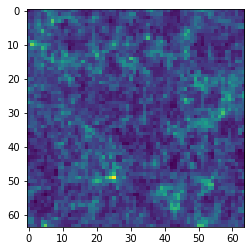

In [14]:
imshow(rho.numpy()[0].sum(axis=0))

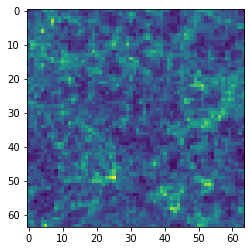

In [7]:
# That's centrals alone
imshow(rho.numpy()[0].sum(axis=0))

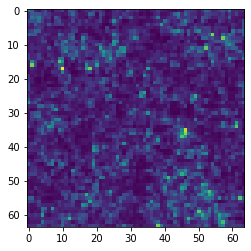

In [9]:
# That's the satellites alone
imshow(rho2.numpy()[0].sum(axis=1))